In [1]:
import random
from copy import deepcopy
from itertools import product
from pathlib import Path

import pandas as pd 
import numpy as np
import glob
from tqdm.notebook import tqdm
import cv2
import os
from sklearn.model_selection import train_test_split
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
from PIL.ExifTags import TAGS

import matplotlib.pyplot as plt
from IPython.display import clear_output

from transformers import (
    ViTForImageClassification, ViTFeatureExtractor, 
    LevitForImageClassification, LevitFeatureExtractor, 
    AutoFeatureExtractor, SwinForImageClassification,
)

model_name = "facebook/levit-128S"  # microsoft/swin-tiny-patch4-window7-224 facebook/deit-tiny-patch16-224 

device = "cuda"
BATCH_SIZE = 16
IMG_SIZE = 10496
IS_CNN = True

def set_seed(seed: int = 1234, precision: int = 10) -> None:
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.set_printoptions(precision=precision)

set_seed(42)

In [2]:
def _compute_metric(
    data_true_batch, data_pred_batch, w = 10496, h = 10496
):
    result_metric = 0
    for data_true, data_pred in zip(data_true_batch, data_pred_batch):
        x_center_true = (data_true[0] + data_true[2]) / 2
        y_center_true = (data_true[1] + data_true[3]) / 2
        x_center_pred = (data_pred[0] + data_pred[2]) / 2
        y_center_pred = (data_pred[1] + data_pred[3]) / 2


        x_metr = abs(x_center_true - x_center_pred)
        y_metr = abs(y_center_true - y_center_pred)
        angle_metr = abs(data_true[4] - data_pred[4])

        metr = 1 - (
            0.7 * 0.5 * (x_metr + y_metr) + 
            0.3 * min(angle_metr, abs(angle_metr - 360))
        )
        result_metric += metr
    return result_metric / (len(data_true_batch) + 1)

## Датасет


In [3]:
image = Image.open("../data/original.tiff")
exifdata = image.getexif()
tags = []
data = []
for tag_id in exifdata:
    # get the tag name, instead of human unreadable tag id
    tag = TAGS.get(tag_id, tag_id)
    data.append(exifdata.get(tag_id))
    # decode bytes 
    if isinstance(data[-1], bytes):
        data[-1] = data[-1].decode()
    tags.append(tag)
    # print(f"{tag:25}: {data}")

# print("TAGS")
# for tag in tags:
#     print(tag)
# print()

# for tag, d in zip(tags, data):
#     print(f"{tag:25}: {d}")

/home/and/miniforge3/envs/mipt-hack/lib/python3.9/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (110166016 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [4]:
print(image.size)
IMG_SIZE = image.size[0]

(10496, 10496)


In [5]:
from math import sin, cos

json_dir = "../data/train/json/"


data_df = pd.DataFrame({'id': [], "left_top_x": [], 'left_top_y': [], "right_bottom_x": [], 'right_bottom_y': [], 'angle': []})

json_true = []
rows = []
for _, _, files in os.walk(json_dir):
  for x in files:
    if x.endswith(".json"):
      data = json.load(open(json_dir + x))
      new_row = {
        'id':x.split(".")[0]+".png", 
        'left_top_x': data["left_top"][0], 
        'left_top_y': data["left_top"][1], 
        'right_bottom_x': data["right_bottom"][0], 
        "right_bottom_y": data["right_bottom"][1], 
        "x_center": (data["left_top"][0] + data["right_bottom"][0]) / 2,
        "y_center": (data["left_top"][1] + data["right_bottom"][1]) / 2,
        'angle': data["angle"]
    }
      rows.append(new_row)

data_df = pd.DataFrame(rows)

In [6]:
data_df.head(5)

,id,left_top_x,left_top_y,right_bottom_x,right_bottom_y,x_center,y_center,angle
0,796.png,1323,2706,2564,3451,1943.5,3078.5,346
1,319.png,2180,1805,1055,2716,1617.5,2260.5,96
2,928.png,7682,8425,7933,9852,7807.5,9138.5,35
3,1058.png,2899,9854,4298,9479,3598.5,9666.5,300
4,344.png,4302,7987,5663,8482,4982.5,8234.5,335


In [7]:
data_df.describe()

,left_top_x,left_top_y,right_bottom_x,right_bottom_y,x_center,y_center,angle
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,5666.133750,5687.818750,5693.117500,5687.990000,5679.625625,5687.904375,183.107500
std,2386.511565,2532.777585,2443.211258,2560.715173,2360.269448,2494.552756,105.093884
min,1028.000000,955.000000,941.000000,877.000000,1552.500000,1540.500000,0.000000
25%,3743.750000,3495.000000,3669.250000,3476.500000,3720.000000,3479.250000,90.750000
50%,5573.000000,5554.000000,5665.000000,5604.500000,5572.000000,5585.000000,183.500000
75%,7623.000000,7926.500000,7693.000000,7921.250000,7610.500000,7919.375000,273.000000
max,10614.000000,10642.000000,10688.000000,10648.000000,9964.500000,9977.500000,359.000000


In [8]:
data_df.to_csv("../data/train.csv", index=False)

In [9]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, labels = self.data_df.iloc[idx]['id'], [self.data_df.iloc[idx]['left_top_x'] / IMG_SIZE, self.data_df.iloc[idx]['left_top_y'] / IMG_SIZE, self.data_df.iloc[idx]['right_bottom_x'] / IMG_SIZE, self.data_df.iloc[idx]['right_bottom_y'] / IMG_SIZE, self.data_df.iloc[idx]['angle'] / 360]

        # читаем картинку. read the image
        image = cv2.imread(f"../data/train/img/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)

        return int(image_name.split(".")[0]), image, torch.tensor(labels).float()
    
    def __len__(self):
        return len(self.data_df)


class ImageDatasetVit(Dataset):
    def __init__(self, data_df, feature_extractor):

        self.data_df = data_df
        # self.transform = transform
        # self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, labels = self.data_df.iloc[idx]['id'], [self.data_df.iloc[idx]['left_top_x'] / IMG_SIZE, self.data_df.iloc[idx]['left_top_y'] / IMG_SIZE, self.data_df.iloc[idx]['right_bottom_x'] / IMG_SIZE, self.data_df.iloc[idx]['right_bottom_y'] / IMG_SIZE, self.data_df.iloc[idx]['angle'] / 360]

        # читаем картинку. read the image
        image = cv2.imread(f"../data/train/img/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # # преобразуем, если нужно. transform it, if necessary
        # if self.transform:
        #     image = self.transform(image)

        image = self.feature_extractor(images=image, return_tensors="pt")
        
        return int(image_name.split(".")[0]), image, torch.tensor(labels).float()
    
    def __len__(self):
        return len(self.data_df)


# class ImageDataset(Dataset):
#     def __init__(self, data_df, transform=None):

#         self.data_df = data_df
#         self.transform = transform

#     def __getitem__(self, idx):
#         # достаем имя изображения и ее лейбл
#         image_name = self.data_df.iloc[idx]['id']
#         keypoints = [
#             [self.data_df.iloc[idx]['left_top_x'], self.data_df.iloc[idx]['left_top_y']],
#             [self.data_df.iloc[idx]['right_bottom_x'], self.data_df.iloc[idx]['right_bottom_y']],
#             [0, 0, self.data_df.iloc[idx]['angle']]
#         ]

#         # читаем картинку. read the image
#         image = cv2.imread(f"../data/train/img/{image_name}")
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         # image = Image.fromarray(image)
        
#         # преобразуем, если нужно. transform it, if necessary
#         if self.transform:
#             transformed = self.transform(image=image, keypoints=keypoints)
#             image, keypoints = transformed["image"], transformed["keypoints"]

#         labels = [
#             keypoints[0][0] / IMG_SIZE, keypoints[0][1] / IMG_SIZE, keypoints[1][0] / IMG_SIZE, keypoints[1][1] / IMG_SIZE, keypoints[2][2] / 360
#         ]
#         return image, torch.tensor(labels).float()
    
#     def __len__(self):
#         return len(self.data_df)

In [10]:
import math
# TODO нормальную трансформацию угла поворота

class HorizontalFlip(A.HorizontalFlip):
    def apply_to_keypoint(self, keypoint, rows, cols, **params):
        x, y, angle, scale = keypoint
        return (cols - 1) - x, y, angle, scale

class VerticalFlip(A.VerticalFlip):
    def apply_to_keypoint(self, keypoint, rows, cols, **params):
        x, y, angle, scale = keypoint
        return x, (rows - 1) - y, angle, scale

class RandomRotate90(A.RandomRotate90):
    def apply_to_keypoint(self, keypoint, factor=0, rows=IMG_SIZE, cols=IMG_SIZE, **params):
        x, y, angle, scale = keypoint[:4]

        if factor not in {0, 1, 2, 3}:
            raise ValueError("Parameter n must be in set {0, 1, 2, 3}")

        if factor == 1:
            x, y, angle = y, (cols - 1) - x, angle - math.pi / 2
        elif factor == 2:
            x, y, angle = (cols - 1) - x, (rows - 1) - y, angle - math.pi
        elif factor == 3:
            x, y, angle = (rows - 1) - y, x, angle + math.pi / 2

        return x, y, angle, scale


In [11]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    transforms.Resize(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])


# train_transform = A.Compose([
#     A.Resize(224, 224),
#     # HorizontalFlip(p=0.5),
#     # VerticalFlip(p=0.5),
#     # RandomRotate90(p=0.5),
#     A.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225]),
#     ToTensorV2()
# ], keypoint_params=A.KeypointParams(format='xy'))

# valid_transform = A.Compose([
#     A.Resize(224, 224),
#     A.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225]),
#     ToTensorV2()
# ], keypoint_params=A.KeypointParams(format='xy'))

In [12]:
# читаем датасет
data_df = pd.read_csv("../data/train.csv")

In [13]:
from os import listdir

print("Обучающей выборки " ,len(listdir("../data/train/img")))
print("Тестовой выборки " ,len(listdir("../data/test")))

Обучающей выборки  800
Тестовой выборки  400


In [14]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=42)

In [15]:
train_df.shape, valid_df.shape

((640, 8), (160, 8))

In [16]:
train_dataset = ImageDataset(train_df, train_transform) if IS_CNN else ImageDatasetVit(train_df, None)
valid_dataset = ImageDataset(valid_df, valid_transform) if IS_CNN else ImageDatasetVit(valid_df, None)

In [17]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=4, 
                                           drop_last=True,
                                           )

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=BATCH_SIZE,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=4)

## Вспомогательные функции

In [18]:
# def crossvalid(res_model=None, criterion=None, optimizer=None, dataset=None, k_fold=5):
    
#     train_score = pd.Series()
#     val_score = pd.Series()
    
#     total_size = len(dataset)
#     fraction = 1 / k_fold
#     seg = int(total_size * fraction)
#     # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
#     # index: [trll,trlr],[vall,valr],[trrl,trrr]
#     for i in range(k_fold):
#         trll = 0
#         trlr = i * seg
#         vall = trlr
#         valr = i * seg + seg
#         trrl = valr
#         trrr = total_size
        
#         train_left_indices = list(range(trll,trlr))
#         train_right_indices = list(range(trrl,trrr))
        
#         train_indices = train_left_indices + train_right_indices
#         val_indices = list(range(vall,valr))
        
#         train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
#         val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
#         train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
#                                           shuffle=True, num_workers=4)
#         val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
#                                           shuffle=True, num_workers=4)
#         train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
#         train_score.at[i] = train_acc
#         #val_acc = valid(res_model,criterion,optimizer,val_loader)
#         #val_score.at[i] = val_acc
    
#     return train_score,val_score

In [19]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [20]:
def train(
    model, criterion, optimizer, scheduler, train_dataloader, test_dataloader, NUM_EPOCH=15, accum_batch_size=128
):
    train_loss_log = []
    val_loss_log = []
    train_metrics = []
    val_metrics = []
    best_loss = np.inf
        
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for i, (_, imgs, labels) in enumerate(train_dataloader):

            if not IS_CNN:
                for j in imgs:
                    imgs[j] = imgs[j][:, 0].to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                y_pred = model(**imgs).logits
            else:
                imgs = imgs.to(device)
                labels = labels.to(device)

                y_pred = model(imgs)

            accum_iter = accum_batch_size / len(labels)

            loss = criterion(y_pred, labels)
            loss /= accum_iter


            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append((loss.data / y_pred.size(0)).item())
            
            # train_metrics.append(_compute_metric(labels.detach().cpu().tolist(), y_pred.detach().cpu().tolist()))

            if ((i + 1) % accum_iter == 0) or (i + BATCH_SIZE >= len(train_dataloader)):
                optimizer.step()
                optimizer.zero_grad()

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for _, imgs, labels in test_dataloader:
                
                if not IS_CNN:
                    for i in imgs:
                        imgs[i] = imgs[i][:, 0].to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)

                    pred = model(**imgs).logits
                else:
                    imgs = imgs.to(device)
                    labels = labels.to(device)

                    pred = model(imgs)

                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred == labels).sum()
        
        val_loss_log.append(val_loss / val_size)
        val_metrics.append(_compute_metric(labels.cpu().tolist(), sigmoid(pred).cpu().tolist()))

        scheduler.step(loss)

        if val_loss_log[-1] < best_loss:
            best_loss = val_loss_log[-1]
            best_model = deepcopy(model)
            torch.save(best_model.state_dict(), "best.pth")

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')

        print('Train loss:', (train_loss / train_size) * 100)
        print('Val loss:', (val_loss / val_size) * 100)
        # print('Train score:', np.mean(train_metrics))
        print('Last Val score:', val_metrics[-1])
        print('Best Val score:', max(val_metrics))
    return best_model, train_loss_log, val_loss_log

## Модель

In [21]:
torch.cuda.empty_cache()

In [22]:
# Подргружаем модель

# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
# model.fc = nn.Linear(model.fc.in_features, 5)

model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)

# model = LevitForImageClassification.from_pretrained(model_name)
# # model.classifier = nn.Linear(
# #     model.classifier.in_features, 5
# # )
# model.classifier.linear = nn.Linear(
#     model.classifier.linear.in_features, 5
# )


model = model.to(device)
criterion = torch.nn.SmoothL1Loss()
sigmoid = torch.nn.Sigmoid()

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2, verbose=True)

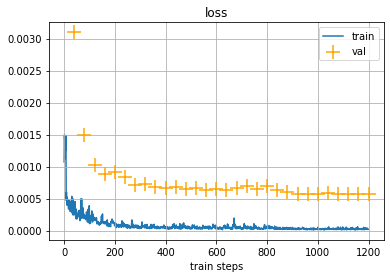

Train loss: 0.00264671012701001
Val loss: 0.05750376411015167
Last Val score: 0.7920482351978803
Best Val score: 0.7956511931863669


In [24]:
best_model, train_loss_log, val_loss_log = train(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    train_loader, 
    valid_loader, 
    30
)

## Посчитаем метрику

In [25]:
model.eval()
best_model.eval()
print()

In [26]:
preds = []
gt = []
with torch.no_grad():
    for _, imgs, labels in valid_loader:
        
        if IS_CNN:
            imgs = imgs.to(device)
            labels = labels.to(device)

            pred = sigmoid(model(imgs))
        else:
            for i in imgs:
                imgs[i] = imgs[i][:, 0].to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            pred = sigmoid(model(**imgs).logits)

        preds.extend(pred.cpu().tolist())
        gt.extend(labels.cpu().tolist())
_compute_metric(gt, preds)

0.8022821901474577

In [27]:
preds = []
gt = []
with torch.no_grad():
    for _, imgs, labels in valid_loader:
        
        if IS_CNN:
            imgs = imgs.to(device)
            labels = labels.to(device)

            pred = sigmoid(best_model(imgs))
        else:
            for i in imgs:
                imgs[i] = imgs[i][:, 0].to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            pred = sigmoid(best_model(**imgs).logits)

        preds.extend(pred.cpu().tolist())
        gt.extend(labels.cpu().tolist())
_compute_metric(gt, preds)

0.8014362433686655

In [30]:
# levit123s - 0.8037
# levit192 - 0.8003


# CatBoost Aggregation

In [89]:
from catboost import CatBoostRegressor

sigmoid = torch.nn.Sigmoid()

class TestData(Dataset):
    def __init__(self, images_paths, feature_extractor=None, transform=None):
        self.feature_extractor = feature_extractor
        self.images_paths = images_paths
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.images_paths[idx])

        if self.feature_extractor is not None:
            image = self.feature_extractor(images=image, return_tensors="pt")
        else:
            image = self.transform(image)

        return int(str(self.images_paths[idx].name).split(".")[0]), image
        
    def __len__(self):
        return len(self.images_paths)

models_weights = [
    "best_vit_0.78.pth", 
    "best_levit_0.79.pth", 
    "best_swin.pth", 
    "best_res50_l1_0.80.pth", 
    "best_effb3_0.80.pth"
]
img_sizes = [
    224, 
    224, 
    224, 
    224, 
    300
]

In [90]:
cv_models = []

# model_name = "google/vit-base-patch16-224"
# model = ViTForImageClassification.from_pretrained(model_name)
# model.classifier = nn.Linear(model.classifier.in_features, 5)
# feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
# model.load_state_dict(torch.load(models_weights[0]))
# cv_models.append({"name": "transformer", "model": model, "feature_extractor": feature_extractor})


model_name = "facebook/levit-128S"
model = LevitForImageClassification.from_pretrained(model_name)
model.classifier.linear = nn.Linear(model.classifier.linear.in_features, 5)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model.load_state_dict(torch.load(models_weights[1]))
cv_models.append({"name": "transformer", "model": model, "feature_extractor": feature_extractor})


# model_name = "microsoft/swin-tiny-patch4-window7-224"
# model = SwinForImageClassification.from_pretrained(model_name)
# model.classifier = nn.Linear(model.classifier.in_features, 5)
# feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
# model.load_state_dict(torch.load(models_weights[2]))
# cv_models.append({"name": "transformer", "model": model, "feature_extractor": feature_extractor})


model_name = "resnet50_l1"
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, 5)
model.load_state_dict(torch.load(models_weights[3]))
cv_models.append({"name": "cnn", "model": model, "feature_extractor": None})

model_name = "effb3_l1"
model = models.efficientnet_b3(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)
model.load_state_dict(torch.load(models_weights[4]))
cv_models.append({"name": "cnn", "model": model, "feature_extractor": None})

for model in cv_models:
    model["model"].to(device)
    model["model"].eval()

Some weights of the model checkpoint at facebook/levit-128S were not used when initializing LevitForImageClassification: ['classifier_distill.batch_norm.num_batches_tracked', 'classifier_distill.linear.weight', 'classifier_distill.batch_norm.bias', 'classifier_distill.batch_norm.running_mean', 'classifier_distill.batch_norm.weight', 'classifier_distill.batch_norm.running_var', 'classifier_distill.linear.bias']
- This IS expected if you are initializing LevitForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LevitForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [92]:
# generate train_df
def generate_preds_df(model_num, pred_df, model, dataset):
    rows = []
    for img_id, img, labels in tqdm(dataset):
        labels = labels.tolist()
        with torch.no_grad():
            if is_cnn:
                img = img.unsqueeze(0).to(device)
                pred = sigmoid(model["model"](img)).squeeze(0).cpu().tolist()
            else:
                for i in img:
                    img[i] = img[i].to(device, non_blocking=True)
                pred = model["model"](**img).logits
                pred = sigmoid(pred).squeeze(0).cpu().tolist()
            row = {
                'id': img_id, 
                "left_top_x": pred[0], 
                'left_top_y': pred[1], 
                "right_bottom_x": pred[2], 
                'right_bottom_y': pred[3], 
                'angle': pred[4],
                "gt_left_top_x": labels[0], 
                'gt_left_top_y': labels[1], 
                "gt_right_bottom_x": labels[2], 
                'gt_right_bottom_y': labels[3], 
                'gt_angle': labels[4],
            }
            rows.append(row)
    data_df = pd.DataFrame(rows)
    if model_num == 0:
        pred_df = data_df
    else:
        data_df = data_df.drop(["gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"], axis=1)
        pred_df = pred_df.merge(
            data_df, 
            on="id", 
            suffixes=("", f"_{model_num}")
        )

    return pred_df


pred_train_df = None
pred_valid_df = None

for model_num, (model, img_size) in enumerate(zip(cv_models, [224, 224, 300])):
    is_cnn = model["name"] == "cnn"

    train_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])
    test_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = ImageDatasetVit(train_df, feature_extractor) if not is_cnn else ImageDataset(train_df, train_transform)
    valid_dataset = ImageDatasetVit(valid_df, feature_extractor) if not is_cnn else ImageDataset(valid_df, test_transform)

    pred_train_df = generate_preds_df(model_num, pred_train_df, model, train_dataset)
    pred_valid_df = generate_preds_df(model_num, pred_valid_df, model, valid_dataset)

    print(f"Model {model_num} predictions generated!")


  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Model 0 predictions generated!


  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Model 1 predictions generated!


  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

Model 2 predictions generated!


In [19]:
# pred_train_df.to_csv("../data/agg_pred/train.csv", index=False)
# pred_valid_df.to_csv("../data/agg_pred/valid.csv", index=False)

In [20]:
# pred_train_df = pd.read_csv("../data/agg_pred/train.csv")
# pred_valid_df = pd.read_csv("../data/agg_pred/valid.csv")

In [94]:
# # Train AGG Regressor

class Regressor(nn.Module):
  def __init__(self, in_features=25):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(in_features, 512),
      nn.ELU(),
      nn.Linear(512, 256),
      nn.ELU(),
      nn.Linear(256, 64),
      nn.ELU(),
      nn.Linear(64, 32),
      nn.ELU(),
      nn.Linear(32, 5),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x)


pred_train_data = pred_train_df.drop(["id", "gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"], axis=1)
pred_valid_data = pred_valid_df.drop(["id", "gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"], axis=1)

gt_train = pred_train_df[["gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"]]
gt_valid = pred_valid_df[["gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"]]


# # CAT
# regressor = CatBoostRegressor(
#     loss_function='MultiRMSE',
#     iterations=2500,
# )

# regressor.fit(pred_train_data, gt_train, eval_set=(pred_valid_data, gt_valid), verbose=1)
# print("Saving model")
# regressor.save_model("regressor.cbm")


### NN
regressor = Regressor(pred_train_data.shape[-1])
regressor.to(device)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(regressor.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.3, patience=300, verbose=True)
train_metrics, val_metrics = [], []
best_score = 0
for epoch in tqdm(range(5000)):
    regressor.train()
    train_pred = []
    data = torch.from_numpy(pred_train_data.values).float().to(device)
    labels = torch.from_numpy(gt_train.values).float().to(device)
    pred = regressor(data)
    loss = criterion(pred, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_pred.extend(pred.cpu().tolist())


    regressor.eval()
    val_pred = []
    with torch.no_grad():
        data = torch.from_numpy(pred_valid_data.values).float().to(device)
        pred = regressor(data)        
        val_pred.extend(pred.cpu().tolist())

    train_metrics.append(_compute_metric(gt_train.values, train_pred))
    val_metrics.append(_compute_metric(gt_valid.values, val_pred))

    if val_metrics[-1] > best_score:
        best_regressor = deepcopy(regressor)
        best_score = val_metrics[-1]

    scheduler.step(val_metrics[-1])

    print('Last Train score:', train_metrics[-1], ' Best Val score:', max(val_metrics))


0:	learn: 0.5496335	test: 0.5209627	best: 0.5209627 (0)	total: 5.7ms	remaining: 14.2s
1:	learn: 0.5383442	test: 0.5131493	best: 0.5131493 (1)	total: 11.5ms	remaining: 14.3s
2:	learn: 0.5271662	test: 0.5055954	best: 0.5055954 (2)	total: 17ms	remaining: 14.2s
3:	learn: 0.5164464	test: 0.4983161	best: 0.4983161 (3)	total: 21.9ms	remaining: 13.6s
4:	learn: 0.5053648	test: 0.4911779	best: 0.4911779 (4)	total: 27ms	remaining: 13.5s
5:	learn: 0.4946891	test: 0.4836522	best: 0.4836522 (5)	total: 31.8ms	remaining: 13.2s
6:	learn: 0.4843070	test: 0.4771426	best: 0.4771426 (6)	total: 36.8ms	remaining: 13.1s
7:	learn: 0.4742273	test: 0.4702805	best: 0.4702805 (7)	total: 42.5ms	remaining: 13.2s
8:	learn: 0.4642507	test: 0.4635747	best: 0.4635747 (8)	total: 47.6ms	remaining: 13.2s
9:	learn: 0.4543805	test: 0.4566949	best: 0.4566949 (9)	total: 52.7ms	remaining: 13.1s
10:	learn: 0.4450980	test: 0.4504852	best: 0.4504852 (10)	total: 58ms	remaining: 13.1s
11:	learn: 0.4358990	test: 0.4441505	best: 0.444

KeyboardInterrupt: 

In [24]:
# 0.8960
# 8998

In [77]:
# Validation
# val_prediction = regressor.predict(pred_valid_data)
# _compute_metric(gt_valid.values, val_prediction)

best_regressor.eval()
with torch.no_grad():
    val_prediction = best_regressor(torch.from_numpy(pred_valid_data.values).float().to(device)).cpu().tolist()
_compute_metric(gt_valid.values, val_prediction)

0.899830094926632

In [ ]:
torch.save(best_regressor.state_dict(), "best_regressor.pth")

# Inference

In [79]:
def generate_preds_df_test(model_num, pred_df, model, dataset):
    rows = []
    for img_id, img in tqdm(dataset):
        with torch.no_grad():
            if model["name"] == "cnn":
                img = img.unsqueeze(0).to(device)
                pred = sigmoid(model["model"](img)).squeeze(0).cpu().tolist()
            else:
                for i in img:
                    img[i] = img[i].to(device, non_blocking=True)
                pred = model["model"](**img).logits
                pred = sigmoid(pred).squeeze(0).cpu().tolist()
            row = {
                'id': img_id, 
                "left_top_x": pred[0], 
                'left_top_y': pred[1], 
                "right_bottom_x": pred[2], 
                'right_bottom_y': pred[3], 
                'angle': pred[4],
            }
            rows.append(row)
    data_df = pd.DataFrame(rows)
    if model_num == 0:
        pred_df = data_df
    else:
        pred_df = pred_df.merge(
            data_df, 
            on="id", 
            suffixes=("", f"_{model_num}")
        )

    return pred_df


In [80]:
images_paths = sorted(list(Path("../data/test").iterdir()), key = lambda p: int(p.name[:-4]))

pred_test_df = None
for model_num, (model, img_size) in enumerate(zip(cv_models, img_sizes)):

    test_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    test_dataset = TestData(images_paths, model["feature_extractor"], test_transform)

    pred_test_df = generate_preds_df_test(model_num, pred_test_df, model, test_dataset)

    print(f"Model {model_num} predictions generated!")

  0%|          | 0/400 [00:00<?, ?it/s]

Model 0 predictions generated!


  0%|          | 0/400 [00:00<?, ?it/s]

Model 1 predictions generated!


  0%|          | 0/400 [00:00<?, ?it/s]

Model 2 predictions generated!


  0%|          | 0/400 [00:00<?, ?it/s]

Model 3 predictions generated!


  0%|          | 0/400 [00:00<?, ?it/s]

Model 4 predictions generated!


In [82]:
pred_test_df.head()

,id,left_top_x,left_top_y,right_bottom_x,right_bottom_y,angle,left_top_x_1,left_top_y_1,right_bottom_x_1,right_bottom_y_1,...,left_top_x_3,left_top_y_3,right_bottom_x_3,right_bottom_y_3,angle_3,left_top_x_4,left_top_y_4,right_bottom_x_4,right_bottom_y_4,angle_4
0,3,0.637598,0.670958,0.632180,0.670010,0.614883,0.638528,0.642091,0.650939,0.624662,...,0.652902,0.637344,0.652524,0.630650,0.647115,0.662059,0.648616,0.678566,0.643412,0.634527
1,4,0.653914,0.563009,0.652142,0.576762,0.618255,0.647678,0.593661,0.673751,0.547832,...,0.669161,0.568832,0.654358,0.556794,0.616778,0.693677,0.553647,0.683510,0.565233,0.599666
2,5,0.594359,0.656074,0.591252,0.662111,0.609928,0.583516,0.628036,0.560144,0.632791,...,0.601870,0.629587,0.588501,0.640756,0.590003,0.608020,0.623977,0.594705,0.634913,0.580221
3,10,0.603859,0.680325,0.600831,0.688349,0.624984,0.641577,0.670854,0.635962,0.672116,...,0.611776,0.653385,0.600589,0.656116,0.590508,0.614032,0.671210,0.607042,0.672465,0.595208
4,11,0.653562,0.580456,0.652886,0.595059,0.615158,0.644302,0.600074,0.648636,0.619430,...,0.678444,0.599020,0.678150,0.589881,0.643287,0.685371,0.582960,0.695230,0.582408,0.661308


In [84]:
ids = pred_test_df.id
# prediction = regressor.predict(pred_test_df.drop("id", axis=1))
with torch.no_grad():
    prediction = best_regressor(torch.from_numpy(pred_test_df.drop("id", axis=1).values).float().to(device)).cpu().tolist()

In [85]:
submit_folder = Path("../data/agg_submit/")
for img_id, pred in tqdm(zip(ids, prediction), total=len(ids)):
    res = {
        "left_top": [pred[0] * IMG_SIZE, pred[1] * IMG_SIZE],
        "right_top": [pred[2] * IMG_SIZE, pred[1] * IMG_SIZE],
        "left_bottom": [pred[0] * IMG_SIZE, pred[3] * IMG_SIZE],
        "right_bottom": [pred[2] * IMG_SIZE, pred[3] * IMG_SIZE],
        "angle": pred[4] * 360
    }
    
    with open(submit_folder / f"{img_id}.json", "w") as f:
        json.dump(res, f)

  0%|          | 0/400 [00:00<?, ?it/s]